The Concrete dataset contains a variety of concrete formulations and the resulting product's compressive strength, which is a measure of how much load that kind of concrete can bear. The task for this dataset is to predict a concrete's compressive strength given its formulation.

In [2]:
#Importing Libraries
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

df = pd.read_csv("fedata/concrete.csv")
df.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


You can see here the various ingredients going into each variety of concrete. We'll see in a moment how adding some additional synthetic features derived from these can help a model to learn important relationships among them.

We'll first establish a baseline by training the model on the un-augmented dataset. This will help us determine whether our new features are actually useful.

Establishing baselines like this is good practice at the start of the feature engineering process. A baseline score can help you decide whether your new features are worth keeping, or whether you should discard them and possibly try something else.

In [3]:
X = df.copy()
y = X.pop("CompressiveStrength")

# Train and score baseline model
baseline = RandomForestRegressor(criterion="absolute_error", random_state=0)
baseline_score = cross_val_score(
    baseline, X, y, cv=5, scoring = "neg_mean_absolute_error"
)

baseline_score = -1 * baseline_score.mean()

print(f"MAE Baseline Score: {baseline_score:.4}")

MAE Baseline Score: 8.232


The Ratios of the features above would be a good predictor of `CompressiveStrenght`.

In [4]:
X = df.copy()
y = X.pop("CompressiveStrength")

#Create Synthetic Features
X["FCRatio"] = X["FineAggregate"] / X["CoarseAggregate"]
X["FCRatio"] = X["FineAggregate"] / X["CoarseAggregate"]
X["AggCmtRatio"] = (X["CoarseAggregate"] + X["FineAggregate"]) / X["Cement"]
X["WtrCmtRatio"] = X["Water"] / X["Cement"]

#Train and score model on dataset with additional ratio features
model = RandomForestRegressor(criterion='absolute_error', random_state=0)
score = cross_val_score(
    model, X, y, cv=5, scoring="neg_mean_absolute_error"
)

score = -1 * score.mean()

print(f"MAE score with Ratio Features: {score:.4}")

MAE score with Ratio Features: 7.948


# Introduction

First encountering a new dataset can sometimes feel overwhelming. You might be presented with hundreds or thousands of features without even a description to go by. Where do you even begin?

A great first step is to construct a ranking with a feature utility metric, a function measuring associations between a feature and the target. Then you can choose a smaller set of the most useful features to develop initially and have more confidence that your time will be well spent.

The metric we'll use is called "mutual information". Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect any kind of relationship, while correlation only detects linear relationships.

Mutual information is a great general-purpose metric and especially useful at the start of feature development when you might not know what model you'd like to use yet. It is:

* easy to use and interpret,
* computationally efficient,
* theoretically well-founded,
* resistant to overfitting, and,
* able to detect any kind of relationship

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('seaborn-whitegrid')

df = pd.read_csv('fedata/autos.csv')
df.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


In [6]:
X = df.copy()
y = X.pop("price")

#Label encoding for categoricals
for colname in X.select_dtypes('object'):
    X[colname], _ = X[colname].factorize()
    
# All discrete features should now have integer dtypes (double check this before using MI!)
discrete_features = X.dtypes == int

In [7]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features = discrete_features)
    mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3] #show a few features with their MI Scores

curb_weight          0.916423
highway_mpg          0.880338
length               0.608652
fuel_system          0.468118
drive_wheels         0.333158
peak_rpm             0.240062
compression_ratio    0.097199
fuel_type            0.047298
Name: MI Scores, dtype: float64

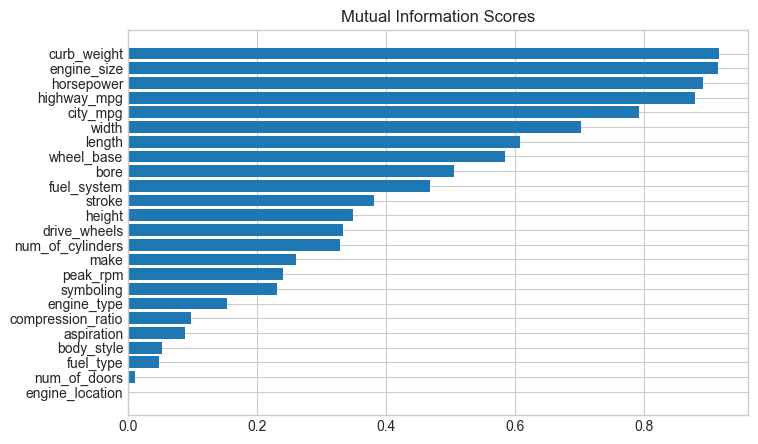

In [8]:
#Add a plot bar to make comparisons easier

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
plt.figure(dpi=100, figsize=(8,5))
plot_mi_scores(mi_scores)

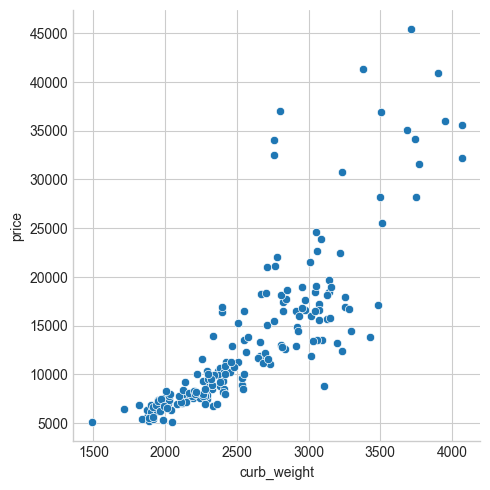

In [9]:
sns.relplot(x='curb_weight', y='price', data=df);

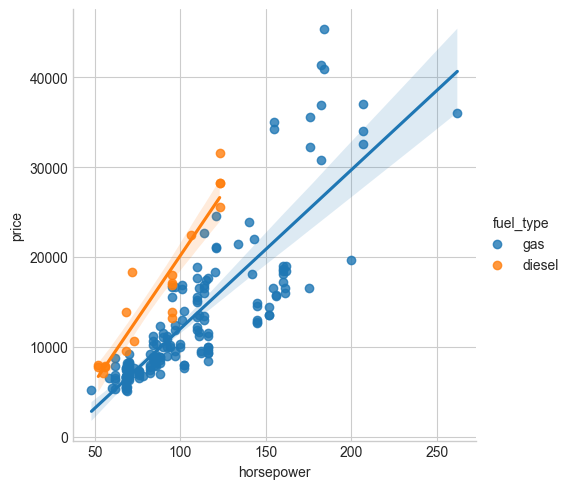

In [10]:
sns.lmplot(x='horsepower', y='price', hue='fuel_type', data=df)

# Creating Features

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
        "axes",
        labelweight="bold",
        labelsize="large",
        titleweight="bold",
        titlesize=14,
        titlepad=10,
)

accidents = pd.read_csv("fedata/accidents.csv")
autos = pd.read_csv("fedata/autos.csv")
concrete = pd.read_csv("fedata/concrete.csv")
customer = pd.read_csv("fedata/customer.csv")

## Matematical Transforms

Relationships among numerical features are often expressed through mathematical formulas, which you'll frequently come across as part of your domain research. In Pandas, you can apply arithmetic operations to columns just as if they were ordinary numbers.

In the Automobile dataset are features describing a car's engine. Research yields a variety of formulas for creating potentially useful new features. The "stroke ratio", for instance, is a measure of how efficient an engine is versus how performant:

In [12]:
autos["stroke_ratio"] = autos.stroke / autos.bore

autos[["stroke", "bore", "stroke_ratio"]].head()

,stroke,bore,stroke_ratio
0,2.68,3.47,0.772334
1,2.68,3.47,0.772334
2,3.47,2.68,1.294776
3,3.40,3.19,1.065831
4,3.40,3.19,1.065831


The more complicated a combination is, the more difficult it will be for a model to learn, like this formula for an engine's displacement a measure of its power

In [13]:
autos["diusplacement"] = (
np.pi * ((0.5 * autos.bore) ** 2 ) * autos.stroke * autos.num_of_cylinders)

C:\Users\PAPATELH\AppData\Local\Temp\ipykernel_34528\1370601473.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(accidents.WindSpeed, shade=True, ax=ax[0])
C:\Users\PAPATELH\AppData\Local\Temp\ipykernel_34528\1370601473.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(accidents.LogWindSpeed, shade=True, ax=ax[1]);


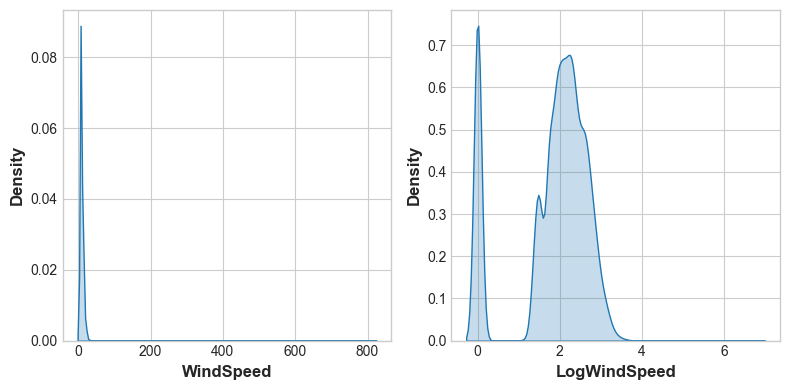

In [14]:
# If the feature has a 0.0 values use np.log1p (log(1+x)) instead of np.log

accidents["LogWindSpeed"] = accidents.WindSpeed.apply(np.log1p)

#plot comparison
fig, ax = plt.subplots(1, 2, figsize=(8,4))
sns.kdeplot(accidents.WindSpeed, shade=True, ax=ax[0])
sns.kdeplot(accidents.LogWindSpeed, shade=True, ax=ax[1]);

# Counts

Features describing the presence or absence of something often come in sets, the set of risk factors for a disease, say. You can aggregate such features by creating a **count.

These features will be binary (`1` for Present, `0` for Absent) or boolean (`True` or `False`). In Python, booleans can be added up just as if they were integers.

In Traffic Accidents are several features indicating whether some roadway object was near the accident. This will create a count of the total number of roadway features nearby using the sum method:

In [15]:
roadway_features = ["Amenity", "Bump", "Crossing", "GiveWay",
    "Junction", "NoExit", "Railway", "Roundabout", "Station", "Stop",
    "TrafficCalming", "TrafficSignal"]

accidents["RoadwayFeatures"] = accidents[roadway_features].sum(axis=1)

accidents[roadway_features + ["RoadwayFeatures"]].head(10)

,Amenity,Bump,Crossing,GiveWay,Junction,NoExit,Railway,Roundabout,Station,Stop,TrafficCalming,TrafficSignal,RoadwayFeatures
0,False,False,False,False,False,False,False,False,False,False,False,False,0
1,False,False,False,False,False,False,False,False,False,False,False,False,0
2,False,False,False,False,False,False,False,False,False,False,False,False,0
3,False,False,False,False,False,False,False,False,False,False,False,False,0
4,False,False,False,False,False,False,False,False,False,False,False,False,0
5,False,False,False,False,True,False,False,False,False,False,False,False,1
6,False,False,False,False,False,False,False,False,False,False,False,False,0
7,False,False,True,False,False,False,False,False,False,False,False,True,2
8,False,False,True,False,False,False,False,False,False,False,False,True,2
9,False,False,False,False,False,False,False,False,False,False,False,False,0


In [16]:
#Another method on creating features

components = [ "Cement", "BlastFurnaceSlag", "FlyAsh", "Water",
               "Superplasticizer", "CoarseAggregate", "FineAggregate"]
concrete["Components"] = concrete[components].gt(0).sum(axis=1)

concrete[components + ["Components"]].head(10)

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Components
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,5
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,5
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,5
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,4


## Building-Up and Breaking-Down Features

Often you'll have complex strings that can usefully be broken into simpler pieces. Some common examples:

* ID numbers: `'123-45-6789'`
* Phone numbers: `'(999) 555-0123'`
* Street addresses: `'8241 Kaggle Ln., Goose City, NV'`
* Internet addresses: `'http://www.kaggle.com`
* Product codes: `'0 36000 29145 2'`
* Dates and times: `'Mon Sep 30 07:06:05 2013'`

In [17]:
customer[["Type", "Level"]] = ( #Create two new features
            customer["Policy"] #from policy feature
            .str               #through string accessor
            .split(" ", expand=True) #by splitting on " "
)                                    # and expanding the results into separate columns

customer[["Policy", "Type", "Level"]].head(10)

,Policy,Type,Level
0,Corporate L3,Corporate,L3
1,Personal L3,Personal,L3
2,Personal L3,Personal,L3
3,Corporate L2,Corporate,L2
4,Personal L1,Personal,L1
5,Personal L3,Personal,L3
6,Corporate L3,Corporate,L3
7,Corporate L3,Corporate,L3
8,Corporate L3,Corporate,L3
9,Special L2,Special,L2


In [18]:
#Another approach
autos["make_and_style"] = autos["make"] + "_" + autos["body_style"]
autos[["make", "body_style", "make_and_style"]].head(10)

,make,body_style,make_and_style
0,alfa-romero,convertible,alfa-romero_convertible
1,alfa-romero,convertible,alfa-romero_convertible
2,alfa-romero,hatchback,alfa-romero_hatchback
3,audi,sedan,audi_sedan
4,audi,sedan,audi_sedan
5,audi,sedan,audi_sedan
6,audi,sedan,audi_sedan
7,audi,wagon,audi_wagon
8,audi,sedan,audi_sedan
9,bmw,sedan,bmw_sedan


## Group Transforms

Finally we have Group transforms, which aggregate information across multiple rows grouped by some category. With a group transform you can create features like: "the average income of a person's state of residence," or "the proportion of movies released on a weekday, by genre." If you had discovered a category interaction, a group transform over that categry could be something good to investigate.

Using an aggregation function, a group transform combines two features: a categorical feature that provides the grouping and another feature whose values you wish to aggregate. For an "average income by state", you would choose State for the grouping feature, mean for the aggregation function, and Income for the aggregated feature. To compute this in Pandas, we use the groupby and transform methods:

In [19]:
customer["AverageIncome"] = (
    customer.groupby('State')
    ["Income"]
    .transform("mean")
)

customer[["State", "Income", "AverageIncome"]].head(10)

,State,Income,AverageIncome
0,Washington,56274,38122.733083
1,Arizona,0,37405.402231
2,Nevada,48767,38369.605442
3,California,0,37558.946667
4,Washington,43836,38122.733083
5,Oregon,62902,37557.283353
6,Oregon,55350,37557.283353
7,Arizona,0,37405.402231
8,Oregon,14072,37557.283353
9,Oregon,28812,37557.283353


In [20]:
customer["StateFreq"] = (
    customer.groupby("State")
    ["State"]
    .transform("count")
    / customer.State.count()
)

customer[["State", "StateFreq"]].head(10)

,State,StateFreq
0,Washington,0.087366
1,Arizona,0.186446
2,Nevada,0.096562
3,California,0.344865
4,Washington,0.087366
5,Oregon,0.284760
6,Oregon,0.284760
7,Arizona,0.186446
8,Oregon,0.284760
9,Oregon,0.284760


In [21]:
# Create Splits
df_train = customer.sample(frac=0.5)
df_valid = customer.drop(df_train.index)

#create the average claim amount by coverage type on the training set
df_train["AverageClaim"] = df_train.groupby("Coverage")["ClaimAmount"].transform("mean")

#Merge the values into a the validation set
df_valid = df_valid.merge(
    df_train[["Coverage", "AverageClaim"]].drop_duplicates(),
    on="Coverage",
    how="left",
)

df_valid[["Coverage", "AverageClaim"]].head(10)

,Coverage,AverageClaim
0,Premium,653.595103
1,Basic,373.991106
2,Basic,373.991106
3,Basic,373.991106
4,Premium,653.595103
5,Basic,373.991106
6,Basic,373.991106
7,Basic,373.991106
8,Basic,373.991106
9,Basic,373.991106


In [22]:
#New Exercise 
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import xgboost as xgb

def score_dataset(X, y, model=XGBRegressor()):
    #Label Encoding for categoricals
    for colname in X.select_dtypes(["category","object"]):
        X[colname], _ = X[colname].factorize()
    #Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring='neg_mean_squared_log_error')
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

#Prepare Data
df = pd.read_csv("fedata/ames.csv")
X=df.copy()
y = X.pop("SalePrice")

In [23]:
X_1 = pd.DataFrame()
X_1["LivLotRatio"] = df.GrLivArea / df.LotArea
X_1["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
X_1["TotalOutsideSF"] = df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + df.Threeseasonporch + df.ScreenPorch

#OneHotEncoding

X_new = pd.get_dummies(df.Categorical, prefix="Cat")

#Multiply row by row

X_new = X_new.mul(df.Continuous, axis=0)

#Join the new features to the features set

X = X.join(X_new)

In [25]:
#Interaction with Categorical
X_2 = pd.get_dummies(df.BldgType, prefix="Bldg")
X_2 = X_2.mul(df.GrLivArea, axis=0)

In [26]:
#Count Feature
X_3 = pd.DataFrame()
X_3["PorchTypes"] = df[[
     "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "Threeseasonporch",
    "ScreenPorch",
]].gt(0.0).sum(axis=1)

In [27]:
df.MSSubClass.unique()

array(['One_Story_1946_and_Newer_All_Styles', 'Two_Story_1946_and_Newer',
       'One_Story_PUD_1946_and_Newer',
       'One_and_Half_Story_Finished_All_Ages', 'Split_Foyer',
       'Two_Story_PUD_1946_and_Newer', 'Split_or_Multilevel',
       'One_Story_1945_and_Older', 'Duplex_All_Styles_and_Ages',
       'Two_Family_conversion_All_Styles_and_Ages',
       'One_and_Half_Story_Unfinished_All_Ages',
       'Two_Story_1945_and_Older', 'Two_and_Half_Story_All_Ages',
       'One_Story_with_Finished_Attic_All_Ages',
       'PUD_Multilevel_Split_Level_Foyer',
       'One_and_Half_Story_PUD_All_Ages'], dtype=object)

In [28]:
X_4 = pd.DataFrame()
X_4["MSClass"] = df.MSSubClass.str.split("_", n=1, expand=True)[0]

In [30]:
X_5 = pd.DataFrame()

X_5["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")

In [31]:
X_new = X.join([X_1,X_2,X_3,X_4,X_5])
score_dataset(X_new,y)

0.13847331622461567

# Clustering with K-Means

This lesson and the next make use of what are known as unsupervised learning algorithms. Unsupervised algorithms don't make use of a target; instead, their purpose is to learn some property of the data, to represent the structure of the features in a certain way. In the context of feature engineering for prediction, you could think of an unsupervised algorithm as a "feature discovery" technique.

Clustering simply means the assigning of data points to groups based upon how similar the points are to each other. A clustering algorithm makes "birds of a feather flock together," so to speak.

When used for feature engineering, we could attempt to discover groups of customers representing a market segment, for instance, or geographic areas that share similar weather patterns. Adding a feature of cluster labels can help machine learning models untangle complicated relationships of space or proximity.

### k-Means Clustering

There are a great many clustering algorithms. They differ primarily in how they measure "similarity" or "proximity" and in what kinds of features they work with. The algorithm we'll use, k-means, is intuitive and easy to apply in a feature engineering context. Depending on your application another algorithm might be more appropriate.

K-means clustering measures similarity using ordinary straight-line distance (Euclidean distance, in other words). It creates clusters by placing a number of points, called centroids, inside the feature-space. Each point in the dataset is assigned to the cluster of whichever centroid it's closest to. The "k" in "k-means" is how many centroids (that is, clusters) it creates. You define the k yourself.

You could imagine each centroid capturing points through a sequence of radiating circles. When sets of circles from competing centroids overlap they form a line. The result is what's called a Voronoi tessallation. The tessallation shows you to what clusters future data will be assigned; the tessallation is essentially what k-means learns from its training data.

In [32]:
#Example

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

df = pd.read_csv("fedata/housing.csv")
X = df.loc[:,["MedInc","Latitude","Longitude"]]
X.head()

,MedInc,Latitude,Longitude
0,8.3252,37.88,-122.23
1,8.3014,37.86,-122.22
2,7.2574,37.85,-122.24
3,5.6431,37.85,-122.25
4,3.8462,37.85,-122.25


In [34]:
#Create cluster feature
kmeans = KMeans(n_clusters=6)
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")

X.head()

,MedInc,Latitude,Longitude,Cluster
0,8.3252,37.88,-122.23,3
1,8.3014,37.86,-122.22,3
2,7.2574,37.85,-122.24,3
3,5.6431,37.85,-122.25,3
4,3.8462,37.85,-122.25,1


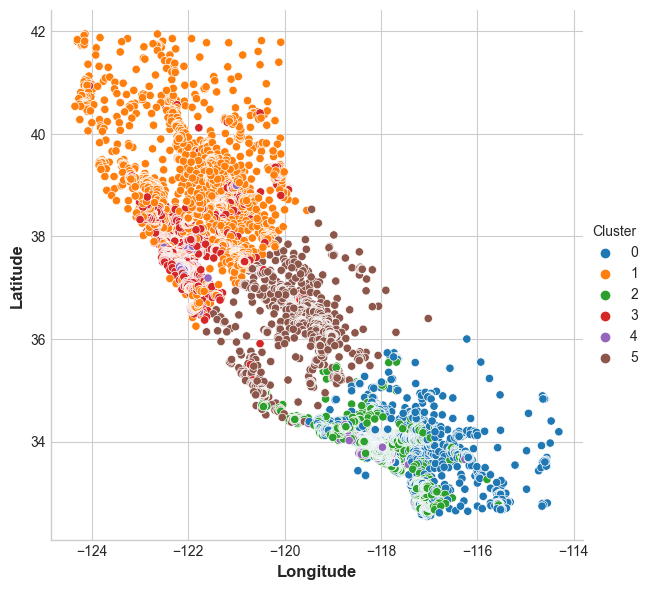

In [35]:
sns.relplot(x="Longitude", y="Latitude", hue="Cluster", data=X, height=6);

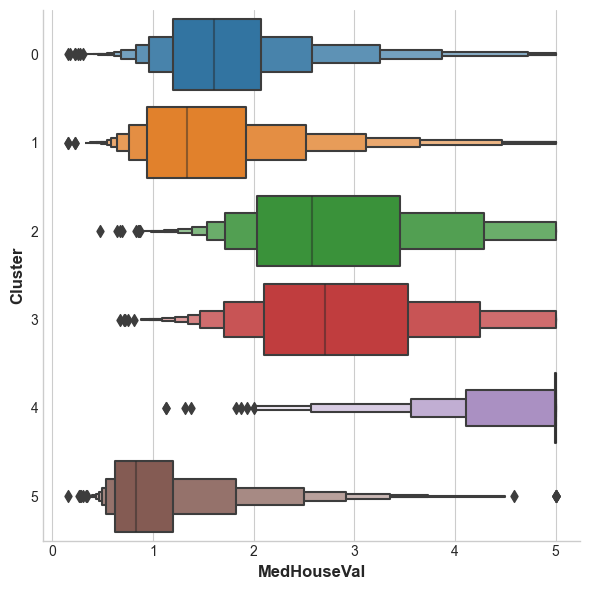

In [36]:
X["MedHouseVal"] = df["MedHouseVal"]
sns.catplot(x="MedHouseVal", y="Cluster", data=X, kind="boxen", height=6)

In [37]:
#Exercise: Clustering with K-Means

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

#Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

#prepare data
df = pd.read_csv("fedata/ames.csv")

In [42]:
X = df.copy()
y = X.pop("SalePrice")

features = ["LotArea","TotalBsmtSF","FirstFlrSF","SecondFlrSF","GrLivArea"]

#$Standarize
X_scaled = X.loc[:,features]
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)

# Fit the KMeans model to X_scaled and create the cluster labels
kmeans = KMeans(n_clusters=10,n_init=10,random_state=0)
X["Cluster"] = kmeans.fit_predict(X_scaled)

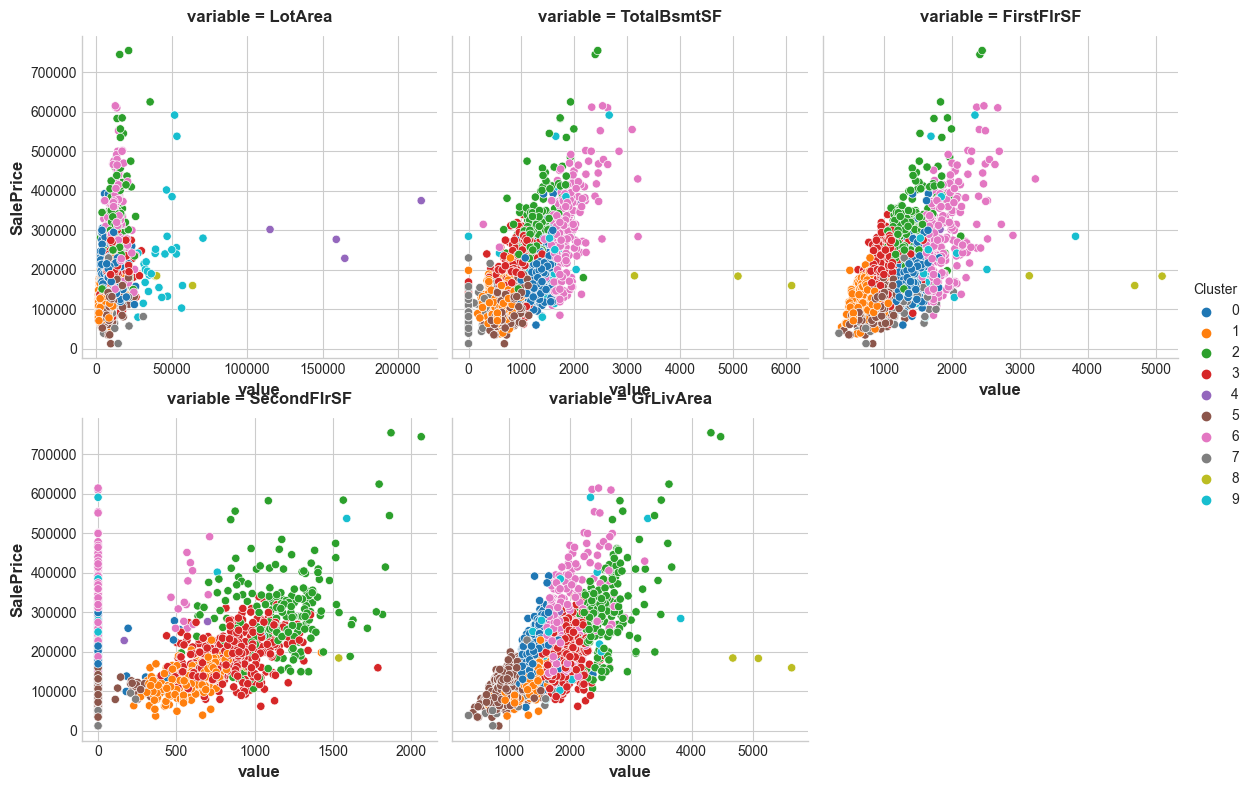

In [43]:
Xy = X.copy()
Xy["Cluster"] = Xy.Cluster.astype("category")
Xy["SalePrice"]  = y
sns.relplot(
    x="value", y="SalePrice", hue="Cluster", col="variable",
    height=4, aspect=1, facet_kws={'sharex':False}, col_wrap=3,
    data=Xy.melt(
        value_vars = features, id_vars=["SalePrice", "Cluster"],
    ),
);

In [44]:
score_dataset(X,y)

0.1404632128875517

## Cluster-Distance Features

In [46]:
kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)

X_cd = kmeans.fit_transform(X_scaled)

#Label features and join dataset
X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
X = X.join(X_cd)

In [47]:
score_dataset(X,y)

0.1414333744272644

# Principal Component Analysis

In the previous lesson we looked at our first model-based method for feature engineering: clustering. In this lesson we look at our next: principal component analysis (PCA). Just like clustering is a partitioning of the dataset based on proximity, you could think of PCA as a partitioning of the variation in the data. PCA is a great tool to help you discover important relationships in the data and can also be used to create more informative features.

(Technical note: PCA is typically applied to standardized data. With standardized data "variation" means "correlation". With unstandardized data "variation" means "covariance". All data in this course will be standardized before applying PCA.)


There are two ways you could use PCA for feature engineering.

The first way is to use it as a descriptive technique. Since the components tell you about the variation, you could compute the MI scores for the components and see what kind of variation is most predictive of your target. That could give you ideas for kinds of features to create -- a product of 'Height' and 'Diameter' if 'Size' is important, say, or a ratio of 'Height' and 'Diameter' if Shape is important. You could even try clustering on one or more of the high-scoring components.

The second way is to use the components themselves as features. Because the components expose the variational structure of the data directly, they can often be more informative than the original features. Here are some use-cases:

* Dimensionality reduction: When your features are highly redundant (multicollinear, specifically), PCA will partition out the redundancy into one or more near-zero variance components, which you can then drop since they will contain little or no information.
* Anomaly detection: Unusual variation, not apparent from the original features, will often show up in the low-variance components. These components could be highly informative in an anomaly or outlier detection task.
* Noise reduction: A collection of sensor readings will often share some common background noise. PCA can sometimes collect the (informative) signal into a smaller number of features while leaving the noise alone, thus boosting the signal-to-noise ratio.
* Decorrelation: Some ML algorithms struggle with highly-correlated features. PCA transforms correlated features into uncorrelated components, which could be easier for your algorithm to work with.
PCA basically gives you direct access to the correlational structure of your data. You'll no doubt come up with applications of your own!

In [51]:
#Examples
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

def plot_variance(pca, width=8, dpi=100):
    #create figure
    fig, axs = plt.subplots(1,2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    #Explained Variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0,1.0)
    )
    #Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    #Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_score(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="Mi Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

df = pd.read_csv("fedata/autos.csv")

In [52]:
features = ["highway_mpg", "engine_size", "horsepower", "curb_weight"]

X = df.copy()
y = X.pop("price")
X = X.loc[:, features]

#Standarize
X_scaled = (X - X.mean(axis=0) / X.std(axis=0))

In [53]:
from sklearn.decomposition import PCA

#Create Principal Components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4
0,-12.876074,8.395804,-3.254642,-3.157603
1,-12.876074,8.395804,-3.254642,-3.157603
2,264.922554,32.159068,-17.396629,1.557667
3,-225.007983,6.321536,-10.027453,-1.786750
4,262.737834,-8.084909,-6.639012,-5.785563


In [57]:
loadings = pd.DataFrame(
    pca.components_.T, #transpose the matrix of loadings
    columns=component_names, # so the columns are the principal components
    index=X.columns, #and the rows are the original features
)

loadings

,PC1,PC2,PC3,PC4
highway_mpg,-0.010560,-0.053135,0.105072,0.992988
engine_size,0.067597,0.612969,0.785645,-0.049613
horsepower,0.054912,0.783683,-0.609406,0.107002
curb_weight,0.996144,-0.085358,-0.018606,0.007995


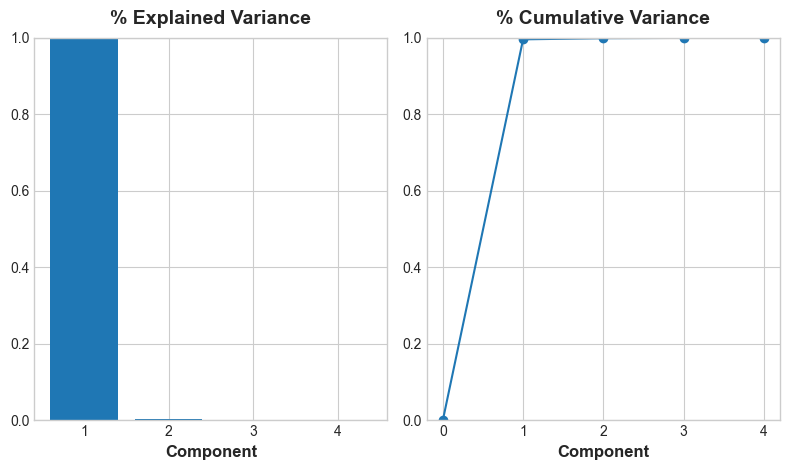

In [58]:
#Look at Explained Variance
plot_variance(pca);

In [60]:
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores

PC1    0.921015
PC3    0.490975
PC2    0.384809
PC4    0.241879
Name: MI Scores, dtype: float64

The third component shows a contrast between horsepower and curb_weight -- sports cars vs. wagons, it seems.

In [61]:
#Show dataframe sorted by PC3
idx = X_pca["PC3"].sort_values(ascending=False).index
cols = ["make", "body_style","horsepower","curb_weight"]
df.loc[idx, cols]

,make,body_style,horsepower,curb_weight
65,mercedes-benz,hardtop,184,3715
64,mercedes-benz,sedan,184,3900
45,jaguar,sedan,262,3950
63,mercedes-benz,convertible,155,3685
43,jaguar,sedan,176,4066
...,...,...,...,...
66,mercury,hatchback,175,2910
186,volvo,sedan,162,3045
124,saab,hatchback,160,2808
125,saab,sedan,160,2847


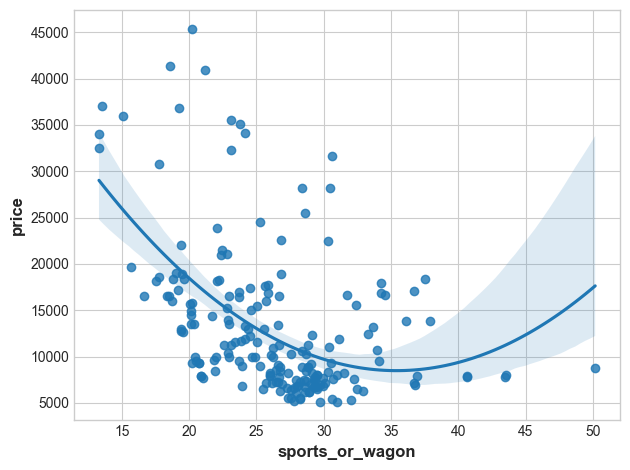

In [63]:
#To Express Contrast lets create a Ratio feature:
df["sports_or_wagon"] = X.curb_weight / X.horsepower
sns.regplot(x="sports_or_wagon", y='price', data=df, order=2);

In [64]:
#Exercise

In [65]:


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


df = pd.read_csv("fedata/ames.csv")

In [66]:
features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

print("Correlation with SalePrice:\n")
print(df[features].corrwith(df.SalePrice))

Correlation with SalePrice:

GarageArea      0.640138
YearRemodAdd    0.532974
TotalBsmtSF     0.632529
GrLivArea       0.706780
dtype: float64


In [67]:
X = df.copy()
y = X.pop("SalePrice")
X = X.loc[:, features]

# `apply_pca`, defined above, reproduces the code from the tutorial
pca, X_pca, loadings = apply_pca(X)
print(loadings)

                   PC1       PC2       PC3       PC4
GarageArea    0.541229  0.102375 -0.038470  0.833733
YearRemodAdd  0.427077 -0.886612 -0.049062 -0.170639
TotalBsmtSF   0.510076  0.360778 -0.666836 -0.406192
GrLivArea     0.514294  0.270700  0.742592 -0.332837


The first component, PC1, seems to be a kind of "size" component, similar to what we saw in the tutorial: all of the features have the same sign (positive), indicating that this component is describing a contrast between houses having large values and houses having small values for these features.

The interpretation of the third component PC3 is a little trickier. The features GarageArea and YearRemodAdd both have near-zero loadings, so let's ignore those. This component is mostly about TotalBsmtSF and GrLivArea. It describes a contrast between houses with a lot of living area but small (or non-existant) basements, and the opposite: small houses with large basements.

In [69]:
X = df.copy()
y = X.pop("SalePrice")

X = X.join(X_pca)

score = score_dataset(X, y)
print(f"Your score: {score:.5f} RMSLE")

Your score: 0.13707 RMSLE


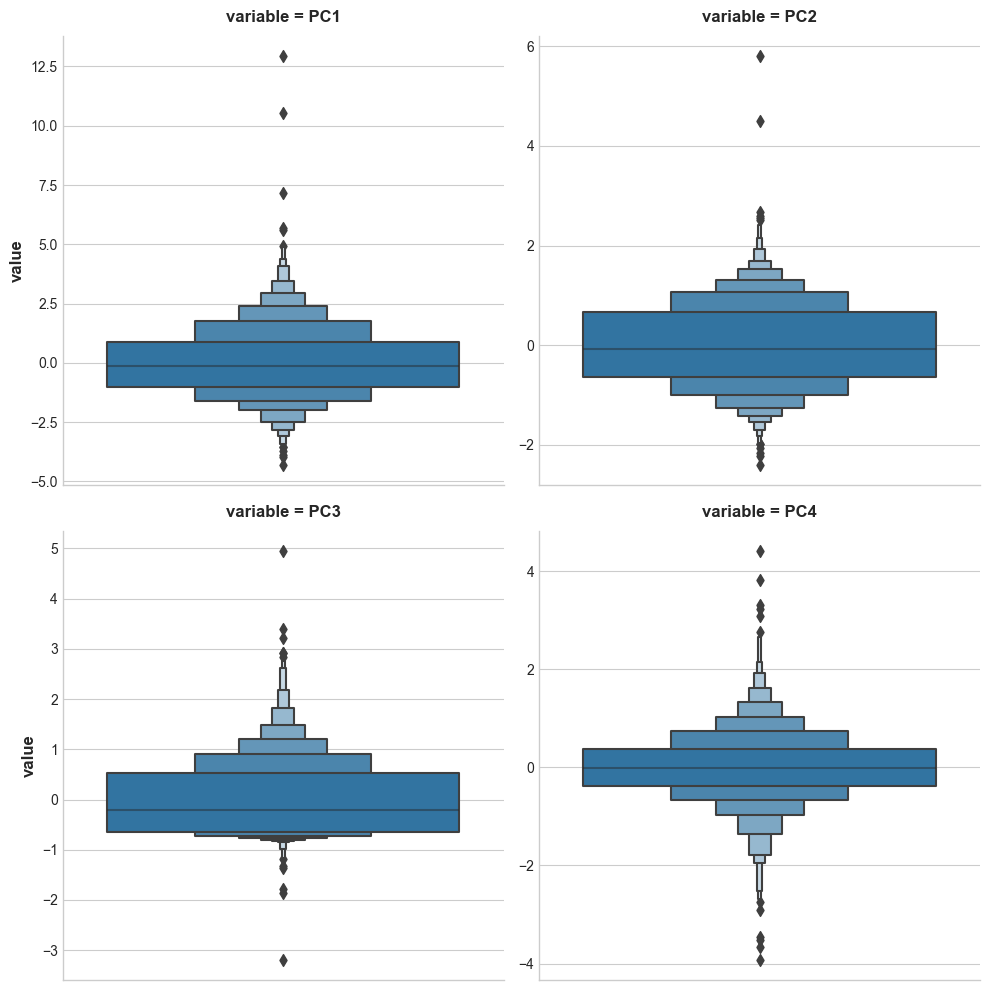

In [70]:
sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

In [71]:
component = "PC1"

idx = X_pca[component].sort_values(ascending=False).index
df.loc[idx, ["SalePrice", "Neighborhood", "SaleCondition"] + features]

,SalePrice,Neighborhood,SaleCondition,GarageArea,YearRemodAdd,TotalBsmtSF,GrLivArea
1498,160000,Edwards,Partial,1418.0,2008,6110.0,5642.0
2180,183850,Edwards,Partial,1154.0,2009,5095.0,5095.0
2181,184750,Edwards,Partial,884.0,2008,3138.0,4676.0
1760,745000,Northridge,Abnorml,813.0,1996,2396.0,4476.0
1767,755000,Northridge,Normal,832.0,1995,2444.0,4316.0
...,...,...,...,...,...,...,...
662,59000,Old_Town,Normal,0.0,1950,416.0,599.0
2679,80500,Brookside,Normal,0.0,1950,0.0,912.0
2879,51689,Iowa_DOT_and_Rail_Road,Abnorml,0.0,1950,0.0,729.0
780,63900,Sawyer,Normal,0.0,1950,0.0,660.0


Notice that there are several dwellings listed as Partial sales in the Edwards neighborhood that stand out. A partial sale is what occurs when there are multiple owners of a property and one or more of them sell their "partial" ownership of the property.

These kinds of sales are often happen during the settlement of a family estate or the dissolution of a business and aren't advertised publicly. If you were trying to predict the value of a house on the open market, you would probably be justified in removing sales like these from your dataset -- they are truly outliers.

# Target Encoding

A target encoding is any kind of encoding that replaces a feature's categories with some number derived from the target.

A simple and effective version is to apply a group aggregation from Lesson 3, like the mean. Using the Automobiles dataset, this computes the average price of each vehicle's make:

In [72]:
import pandas as pd

autos = pd.read_csv("fedata/autos.csv")

In [74]:
autos["make_encoded"] = autos.groupby("make")["price"].transform("mean")
                                      
autos[["make", "price", "make_encoded"]].head(10)

,make,price,make_encoded
0,alfa-romero,13495,15498.333333
1,alfa-romero,16500,15498.333333
2,alfa-romero,16500,15498.333333
3,audi,13950,17859.166667
4,audi,17450,17859.166667
5,audi,15250,17859.166667
6,audi,17710,17859.166667
7,audi,18920,17859.166667
8,audi,23875,17859.166667
9,bmw,16430,26118.750000


encoding = weight * in_category + (1 - weight) * overall

weight = n / (n + m)

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')


df = pd.read_csv("fedata/movielens1m.csv")
df = df.astype(np.uint8, errors='ignore') # reduce memory footprint
print("Number of Unique Zipcodes: {}".format(df["Zipcode"].nunique()))

Number of Unique Zipcodes: 3439


In [76]:
X = df.copy()
y = X.pop('Rating')

X_encode = X.sample(frac=0.25)
y_encode = y[X_encode.index]
X_pretrain = X.drop(X_encode.index)
y_train = y[X_pretrain.index]

In [79]:
from category_encoders import MEstimateEncoder

#Create encoder instance, choose m to control noise.
encoder = MEstimateEncoder(cols=["Zipcode"], m=5.0)

#Fit the Encoder on the encoding Split
encoder.fit(X_encode, y_encode)

#Encode the zip column to create the final training data
X_train = encoder.transform(X_pretrain)

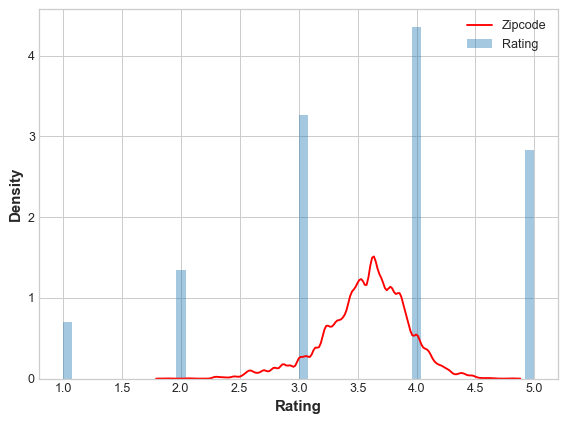

In [80]:
plt.figure(dpi=90)
ax = sns.distplot(y, kde=False, norm_hist=True)
ax = sns.kdeplot(X_train.Zipcode, color='r', ax=ax)
ax.set_xlabel("Rating")
ax.legend(labels=['Zipcode', 'Rating']);

In [83]:
#Exercise Target Encoding
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from category_encoders import MEstimateEncoder
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

#Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')

def score_dataset(X, y, model=XGBRegressor()):
    #Label Encoding for categoricals
    for colname in X.select_dtypes(["category","object"]):
        X[colname], _ = X[colname].factorize()
    #Metric for housing competition is RMSLE
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

df = pd.read_csv("fedata/ames.csv")

In [84]:
df.select_dtypes(["object"]).nunique()

MSSubClass       16
MSZoning          7
Street            2
Alley             3
LotShape          4
LandContour       4
Utilities         3
LotConfig         5
LandSlope         3
Neighborhood     28
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
OverallQual      10
OverallCond       9
RoofStyle         6
RoofMatl          8
Exterior1st      16
Exterior2nd      17
MasVnrType        5
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          6
BsmtCond          6
BsmtExposure      5
BsmtFinType1      7
BsmtFinType2      7
Heating           6
HeatingQC         5
CentralAir        2
Electrical        6
KitchenQual       5
Functional        8
FireplaceQu       6
GarageType        7
GarageFinish      4
GarageQual        6
GarageCond        6
PavedDrive        3
PoolQC            5
Fence             5
MiscFeature       6
SaleType         10
SaleCondition     6
dtype: int64

In [85]:
df["SaleType"].value_counts()

WD       2536
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
VWD         1
Name: SaleType, dtype: int64

The Neighborhood feature looks promising. It has the most categories of any feature, and several categories are rare. Others that could be worth considering are SaleType, MSSubClass, Exterior1st, Exterior2nd. In fact, almost any of the nominal features would be worth trying because of the prevalence of rare categories.

In [86]:
#Encoding split
X_encode = df.sample(frac=0.20, random_state=0)
y_encode = X_encode.pop("SalePrice")

#Training split
X_pretrain = df.drop(X_encode.index)
y_train = X_pretrain.pop("SalePrice")

In [90]:
encoder = MEstimateEncoder(cols=["Neighborhood"], m=1.0)

#Fit Encoder
encoder.fit(X_encode, y_encode)

#Encode the training split
X_train = encoder.transform(X_pretrain, y_train)

Text(0.5, 0, 'SalePrice')

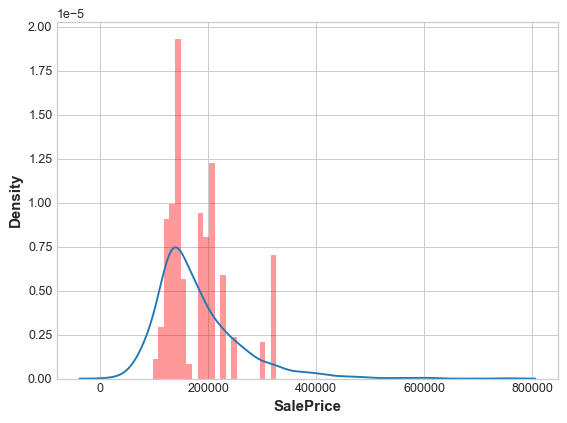

In [91]:
feature = encoder.cols

plt.figure(dpi=90)
ax = sns.distplot(y_train, kde=True, hist=False)
ax = sns.distplot(X_train[feature], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel("SalePrice")

In [92]:
X = df.copy()
y = X.pop("SalePrice")
score_base = score_dataset(X,y)
score_new = score_dataset(X_train, y_train)

print(f"Baseline Score: {score_base:.4f} RMSLE")
print(f"Score with Encoding: {score_new:.4f} RMSLE")

Baseline Score: 0.1428 RMSLE
Score with Encoding: 0.1402 RMSLE


In [93]:
m = 0

X=df.copy()
y = X.pop("SalePrice")

#Create an Uniformative feature
X['Count'] = range(len(X))
X['Count'][1] = 0 #actually need one duplicate value to circumvent error-checking in MEstimateEncoder

#fit and transform on the same dataset
encoder = MEstimateEncoder(cols="Count", m=m)
X = encoder.fit_transform(X,y)

#Results
score = score_dataset(X, y)
print(f"Socore: {score:.4f} RMSLE")

Socore: 0.0293 RMSLE


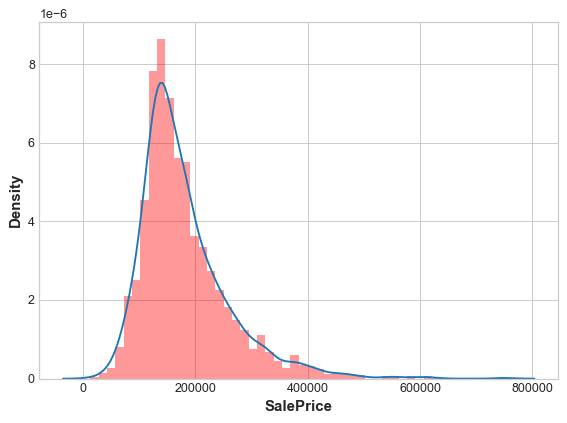

In [95]:
plt.figure(dpi=90)
ax = sns.distplot(y, kde=True, hist=False)
ax = sns.distplot(X["Count"], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel("SalePrice");

Since Count never has any duplicate values, the mean-encoded Count is essentially an exact copy of the target. In other words, mean-encoding turned a completely meaningless feature into a perfect feature.

Now, the only reason this worked is because we trained XGBoost on the same set we used to train the encoder. If we had used a hold-out set instead, none of this "fake" encoding would have transferred to the training data.

The lesson is that when using a target encoder it's very important to use separate data sets for training the encoder and training the model. Otherwise the results can be very disappointing!